Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main
C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main\bcos\common.py:152: UserWarning: Input tensor did not require grad! Has been set automatically to True!
  warnings.warn(


{'prediction': 1, 'explained_class_idx': 1, 'dynamic_linear_weights': tensor([[[[ 2.1068e-03, -1.1374e-03,  6.3266e-04,  ...,  2.2617e-05,
           -2.9598e-05,  5.5841e-05],
          [-4.9710e-04, -4.5443e-03,  6.1282e-03,  ...,  1.3628e-05,
           -5.6069e-05,  3.2939e-05],
          [-1.0242e-04,  2.0061e-03,  1.3127e-02,  ...,  9.4063e-05,
           -1.9541e-05,  1.9446e-05],
          ...,
          [ 7.8280e-04,  5.5828e-04, -3.9874e-04,  ...,  2.3773e-06,
            9.3161e-06,  1.3982e-05],
          [ 7.9478e-04,  8.5725e-04, -9.7306e-05,  ...,  1.3367e-05,
            9.0263e-06,  1.2570e-05],
          [ 2.6457e-04,  5.5327e-04,  3.1860e-04,  ...,  2.9596e-05,
            2.4882e-05,  2.0727e-05]],

         [[ 2.2835e-03, -2.9970e-03,  1.8729e-04,  ...,  4.6337e-05,
           -4.5165e-05,  6.8618e-05],
          [-2.3663e-03, -7.7237e-03,  7.6420e-03,  ...,  4.0029e-05,
           -9.7302e-05,  2.3620e-05],
          [-1.5525e-03,  2.9944e-03,  1.8436e-02,  ...,  

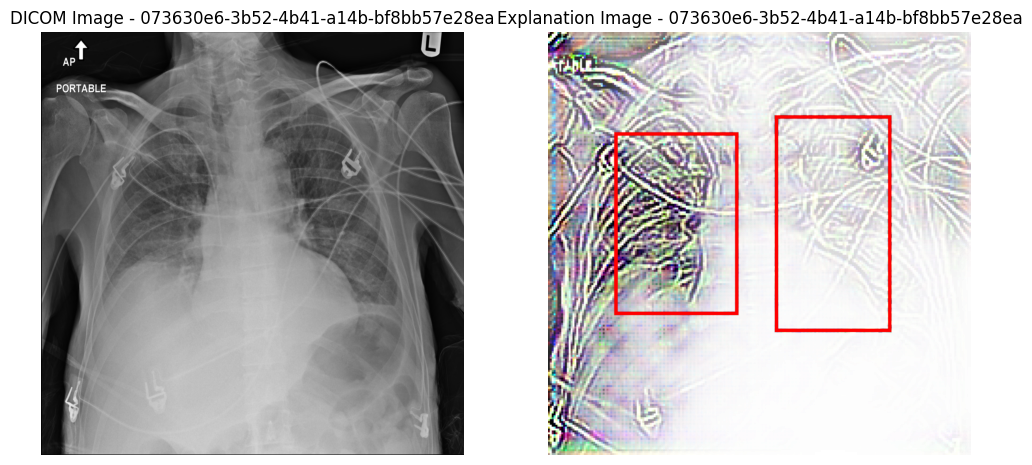

In [8]:
from libraries.energyPointGame import energy_point_game
from libraries.ImageUtil import find_original_image_name
from libraries.bcosconv2d import NormedConv2d

import random
import numpy as np
import torch
import pandas as pd
import pydicom
import os
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt


np.random.seed(0)
random.seed(0)
torch.manual_seed(0)



original_width, original_height = 1024, 1024
explanation_width, explanation_height = 224, 224

image_folder = r"C:\Users\Admin\Documents\rsna-pneumonia-detection-challenge\stage_2_train_images"
explanation_folder = r"C:\Users\Admin\Documents\MasterThesis\prediction_images\onePrediction"
model_path = r"C:\Users\Admin\Documents\MasterThesis\BestPerformingResNet50BCosResult\pneumonia_detection_model_bcos_trans_bestf1_1_24.pth"
csv_path = r"C:\Users\Admin\Documents\rsna-pneumonia-detection-challenge\stage_2_train_labels.csv"



model = torch.hub.load('B-cos/B-cos-v2', 'resnet50', pretrained=True)    
model.fc.linear = NormedConv2d(2048, 2, kernel_size=(1, 1), stride=(1, 1), bias=False) # code from B-cos paper reused to adjust network

state_dict = torch.load(model_path)
model.load_state_dict(state_dict)

patient_id = "073630e6-3b52-4b41-a14b-bf8bb57e28ea"
image_path = os.path.join(image_folder,"073630e6-3b52-4b41-a14b-bf8bb57e28ea.dcm")
dicom = pydicom.dcmread(image_path)
image = Image.fromarray(dicom.pixel_array).convert("RGB")

img_new = model.transform(image)
img_new = img_new[None]
img_new = img_new

model.eval()
logits = model(img_new)
expl = model.explain(img_new)
print(expl)
explanation_image_array = expl['explanation']
explanation_image_array = (explanation_image_array * 255).astype(np.uint8)
explanation_image = Image.fromarray(explanation_image_array)
contribution_map = expl['contribution_map'].squeeze(0)
min_val = contribution_map.min()
max_val = contribution_map.max()

print(f"MinValue {min_val}, MaxVal {max_val}")

normalized_map = (contribution_map - min_val) / (max_val - min_val)


# Plot side by side
plt.figure(figsize=(12, 6))

# DICOM image
plt.subplot(1, 2, 1)
plt.imshow(image, cmap="gray")
plt.title(f"DICOM Image - {patient_id}")
plt.axis("off")

# 
plt.subplot(1, 2, 2)
plt.imshow(explanation_image)
plt.title(f"Explanation Image - {patient_id}")
plt.axis("off")

my_image = r"C:\Users\Admin\Downloads\prediction_comparison\ff5efd4a-0777-41b9-82c7-b73b4073c509_normal_explanation.png"
original_image_name = find_original_image_name(image_folder, my_image)

df = pd.read_csv(csv_path)
scale_x = explanation_width / original_width
scale_y = explanation_height / original_height

filtered_rows = df[(df['patientId'] == '073630e6-3b52-4b41-a14b-bf8bb57e28ea') & (df['Target'] == 1)]

for _, row in filtered_rows.iterrows():
    x, y, width, height = round(row["x"] * scale_x), round(row["y"] * scale_y), round(row["width"] * scale_x), round(row["height"] * scale_y) # not ints
    
    explanation_draw = ImageDraw.Draw(explanation_image)
    explanation_draw.rectangle([(x, y), (x + width, y + height)], outline="red", width=2)

    coordinates_list = [x, y, x + width, y + height]
    coordinates_tensor = torch.tensor(coordinates_list, dtype=torch.int32)
    
    print(coordinates_list)
    
    proportion = energy_point_game(coordinates_tensor, normalized_map)
    print(f"Proportion {proportion}")

plt.imshow(explanation_image)
plt.show()


## bbox and saliency map
#energy_point_game("","")



In [ ]:
import os
import random
import sys
import pickle
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet50
from torchvision.models import ResNet50_Weights
from PIL import Image
import pydicom
from sklearn.model_selection import KFold
from bcosconv2d import NormedConv2d
from torchvision.transforms import functional as TF

from torchvision.transforms import ToPILImage

np.random.seed(0)
random.seed(0)
torch.manual_seed(0)

model_path = r"C:\Users\Admin\Documents\MasterThesis\pneumonia_detection_model_fold_1.pth"
csv_path = r"C:\Users\Admin\Documents\rsna-pneumonia-detection-challenge\stage_2_train_labels.csv"
image_folder = r"C:\Users\Admin\Documents\rsna-pneumonia-detection-challenge\stage_2_train_images"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


torch.hub.list('B-cos/B-cos-v2')

model = torch.hub.load('B-cos/B-cos-v2', 'resnet50', pretrained=True)    
model.fc.linear = NormedConv2d(2048, 1, kernel_size=(1, 1), stride=(1, 1), bias=False) # code from B-cos paper reused to adjust network

state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict)

# Load trained weights (optional)
model = model.to(device)

image_path = os.path.join(image_folder,"db7bce8f-978c-47b1-8b74-7640f7c3625e.dcm")
dicom = pydicom.dcmread(image_path)
image = Image.fromarray(dicom.pixel_array).convert("RGB")

img_new = model.transform(image)
img_new = img_new[None]
img_new = img_new.to(device)

model.eval()
logits = model(img_new)
expl = model.explain(img_new)
print(expl['contribution_map'])
print(expl['contribution_map'].min())
print(expl['contribution_map'].max())


print(expl.keys())
print(logits)



#print(model)

